# Online Retail

## Imports

In [208]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import numpy as np

# Color palette based on Navy & Gold identity
line_color = "#CFBB4A"
text_color = "#101813"
plot_title_color = "#292121"
grid_line_color = "#5E656D"
x_title_color = "#495057"
y_title_color = "#495057"
annotation_color_1 = "#E7E7CA"

# Custom formatter to convert values to £ millions or thousands
def sterling_formatter(x, pos):
    """Custom formatter to convert values to £ millions or thousands"""
    if x >= 1e6:
        return f'£{x*1e-6:.1f}M'
    return f'£{x*1e-3:.0f}K'

#

In [ ]:
# Load dataset
raw = pd.read_excel('Online Retail.xlsx')

Total de registros originais: 541909


## Cleaning

In [16]:
# Create a copy for processing
df = raw.copy()
print(f"Total records: {len(df)}")

# Remove records without product description (name)
df = df.dropna(subset=['Description'])

# Formatting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalRevenue column
df['TotalRevenue'] = round(df['Quantity'] * df['UnitPrice'], 2)

# Identifying negative quantities (Returns/Cancellations)
returns = df[df['Quantity'] < 0]
print(f"Number of returns/cancellations: {len(returns)}")

# Identifying negative prices (Gifts/Stock Adjustments)
adjustments = df[df['UnitPrice'] < 0]
print(f"Number of negative prices: {len(adjustments)}")

# Filtering only valid transactions for inventory demand analysis
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"Cleaned dataset shape: {df.shape}")

Total records: 541909
Number of returns/cancellations: 9762
Number of negative prices: 2
Cleaned dataset shape: (530104, 9)


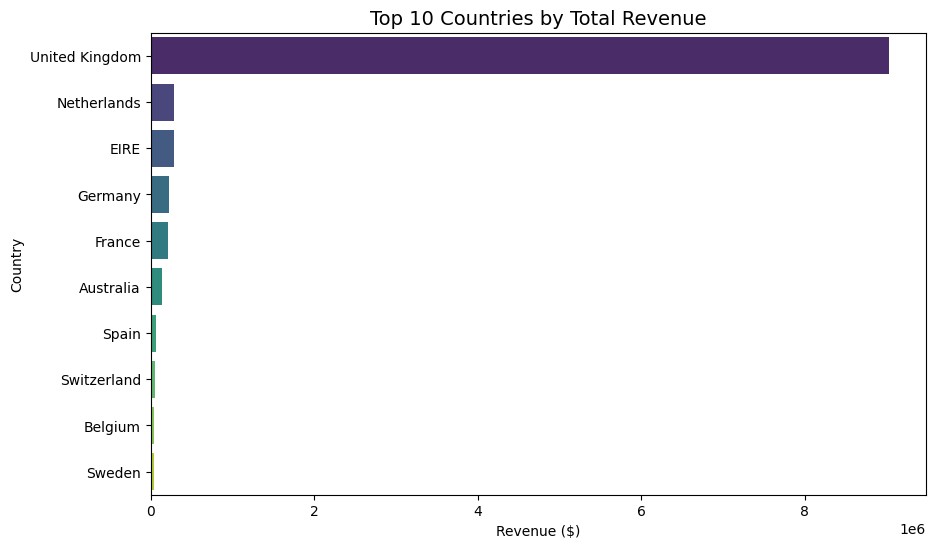

In [21]:
# Grouping by country to see where the money comes from
country_revenue = df.groupby('Country')['TotalRevenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')
plt.title('Top 10 Countries by Total Revenue', fontsize=14)
plt.xlabel('Revenue ($)')
plt.show()

## Exploratory Data Analysis

### Temporal Analysis

#### Revenue by month

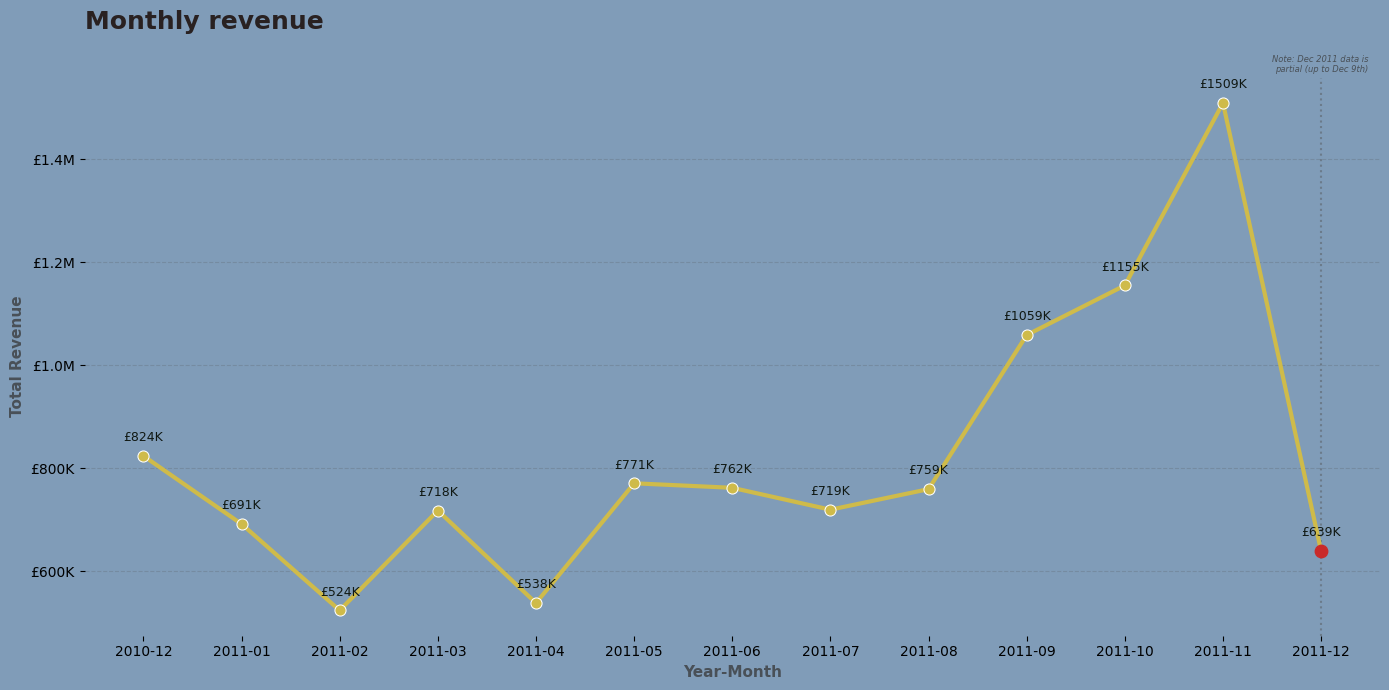

In [214]:
# Grouping revenue by month
monthly_revenue = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalRevenue'].sum().reset_index()
monthly_revenue['MonthLabel'] = monthly_revenue['InvoiceDate'].dt.strftime('%Y-%m')
plt.figure(figsize=(14, 7))

# Plotting the main trend with our Navy & Gold identity
ax = sns.lineplot(data=monthly_revenue, x='MonthLabel', y='TotalRevenue', marker='o', markersize=8, color=line_color, linewidth=3, zorder=3)

# Adding annotations to ALL points
for x, y in enumerate(monthly_revenue['TotalRevenue']):
    plt.text(x, y + (monthly_revenue['TotalRevenue'].max() * 0.015), 
             f'£{y*1e-3:.0f}K', 
             ha='center', 
             va='bottom', 
             fontsize=9, 
             fontweight='normal', 
             color=text_color)

# Highlighting the partial data at the end (December 2011)
plt.scatter(monthly_revenue['MonthLabel'].iloc[-1], monthly_revenue['TotalRevenue'].iloc[-1], color='#c92a2a', s=80, zorder=4)

# Vertical line for the partial data period
plt.axvline(x=len(monthly_revenue)-1, color=grid_line_color, linestyle=':', alpha=0.6)
plt.text(len(monthly_revenue)-0.52, monthly_revenue['TotalRevenue'].max() * 1.04, 
         'Note: Dec 2011 data is\npartial (up to Dec 9th)', 
         color=x_title_color, fontsize=6, fontstyle='italic', ha='right')

# Formatting labels and Title
plt.title('Monthly revenue', fontsize=18, fontweight='bold', pad=35, loc='left', color=plot_title_color)

# Specifying the format in the X-axis title as requested
plt.xlabel('Year-Month', fontsize=11, fontweight='semibold', color=x_title_color)
plt.ylabel('Total Revenue', fontsize=11, fontweight='semibold', color=y_title_color)

# Currency Formatting (Sterling)
ax.yaxis.set_major_formatter(FuncFormatter(sterling_formatter))
sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.3, color=grid_line_color, zorder=1)
plt.tight_layout()
plt.show()

#### Revenue by week

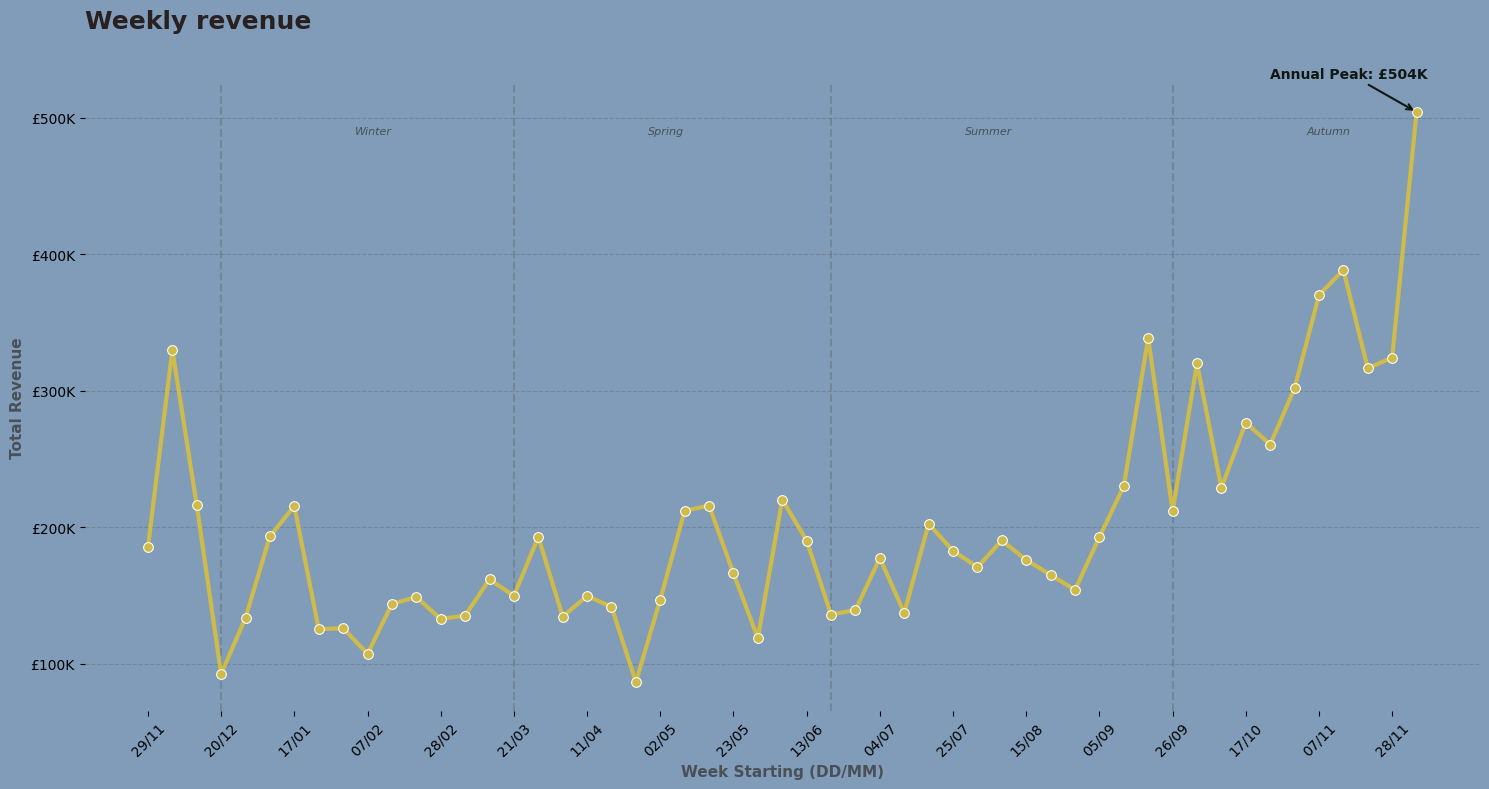

In [211]:
# Grouping and formatting
weekly_revenue = df.groupby(df['InvoiceDate'].dt.to_period('W'))['TotalRevenue'].sum().reset_index()
weekly_revenue['WeekStart_DT'] = weekly_revenue['InvoiceDate'].apply(lambda x: x.start_time)
weekly_revenue['WeekStart'] = weekly_revenue['WeekStart_DT'].dt.strftime('%d/%m')

# Plotting the main line
plt.figure(figsize=(15, 8))
ax = sns.lineplot(data=weekly_revenue, x='WeekStart', y='TotalRevenue', color=line_color, linewidth=3, marker='o', markersize=7, zorder=3)

# Adding seasonal markers
seasons = [
    {'date': '2010-12-21', 'label': 'Winter'},
    {'date': '2011-03-20', 'label': 'Spring'},
    {'date': '2011-06-21', 'label': 'Summer'},
    {'date': '2011-09-23', 'label': 'Autumn'}
]

for season in seasons:
    target_date = pd.to_datetime(season['date'])

    # Find the index of the closest week start
    idx = (weekly_revenue['WeekStart_DT'] - target_date).abs().idxmin()
    
    # Draw vertical line
    plt.axvline(x=idx, color=grid_line_color, linestyle='--', alpha=0.4, zorder=1)
    
    # Add text label near the top of the chart
    plt.text(idx + 5.5, plt.gca().get_ylim()[1] * 0.93, season['label'], 
             rotation=0, color=x_title_color, fontsize=8, 
             ha='left', fontweight='normal', fontstyle='italic')

# Absolute Peak annotation
peak_idx = weekly_revenue['TotalRevenue'].idxmax()
peak_val = weekly_revenue['TotalRevenue'].max()
plt.annotate(f'Annual Peak: {sterling_formatter(peak_val, None)}', 
             xy=(peak_idx, peak_val), xytext=(peak_idx - 6, peak_val * 1.05),
             arrowprops=dict(arrowstyle='->', color=text_color, lw=1.5),
             fontsize=10, color=text_color, fontweight='bold')

# Final styling & formatting
plt.title('Weekly revenue', fontsize=18, fontweight='bold', pad=40, loc='left', color=plot_title_color)
plt.xlabel('Week Starting (DD/MM)', fontsize=11, fontweight='semibold', color=x_title_color)
plt.ylabel('Total Revenue', fontsize=11, fontweight='semibold', color=y_title_color)
ax.yaxis.set_major_formatter(FuncFormatter(sterling_formatter))
plt.xticks(range(0, len(weekly_revenue), 3), weekly_revenue['WeekStart'][::3], rotation=45)
sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.4, color=grid_line_color, zorder=0)
plt.tight_layout()
plt.show()

#### Revenue by weekday

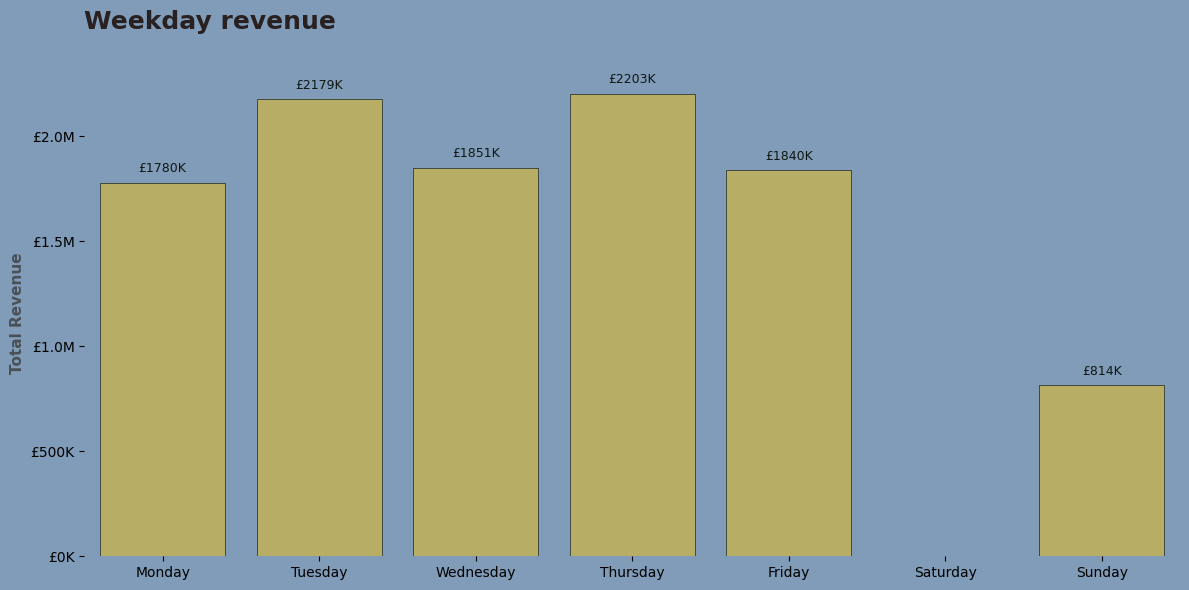

In [213]:
# Grouping by day and ensuring order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_dist = df.groupby('DayOfWeek')['TotalRevenue'].sum().reindex(days_order).reset_index()

# Plotting with the same golden/yellow color for consistency
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=daily_dist, x='DayOfWeek', y='TotalRevenue', color=line_color, edgecolor=text_color, linewidth=0.5, alpha=0.9)

# Adding annotations on top of bars
for p in ax.patches:
    ax.annotate(f'£{p.get_height()*1e-3:.0f}K', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=9, fontweight='normal', color=text_color)

# Layout adjustments matching the Hourly chart
plt.title('Weekday revenue', fontsize=18, fontweight='bold', pad=30, loc='left', color=plot_title_color)
plt.xlabel('')
plt.ylabel('Total Revenue', fontsize=11, fontweight='semibold', color=y_title_color)

# Formatting Axis
ax.yaxis.set_major_formatter(FuncFormatter(sterling_formatter))

# Grid and Spines cleanup
sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0, color=grid_line_color, zorder=0)
plt.tight_layout()
plt.show()

#### Revenue by hour of the day

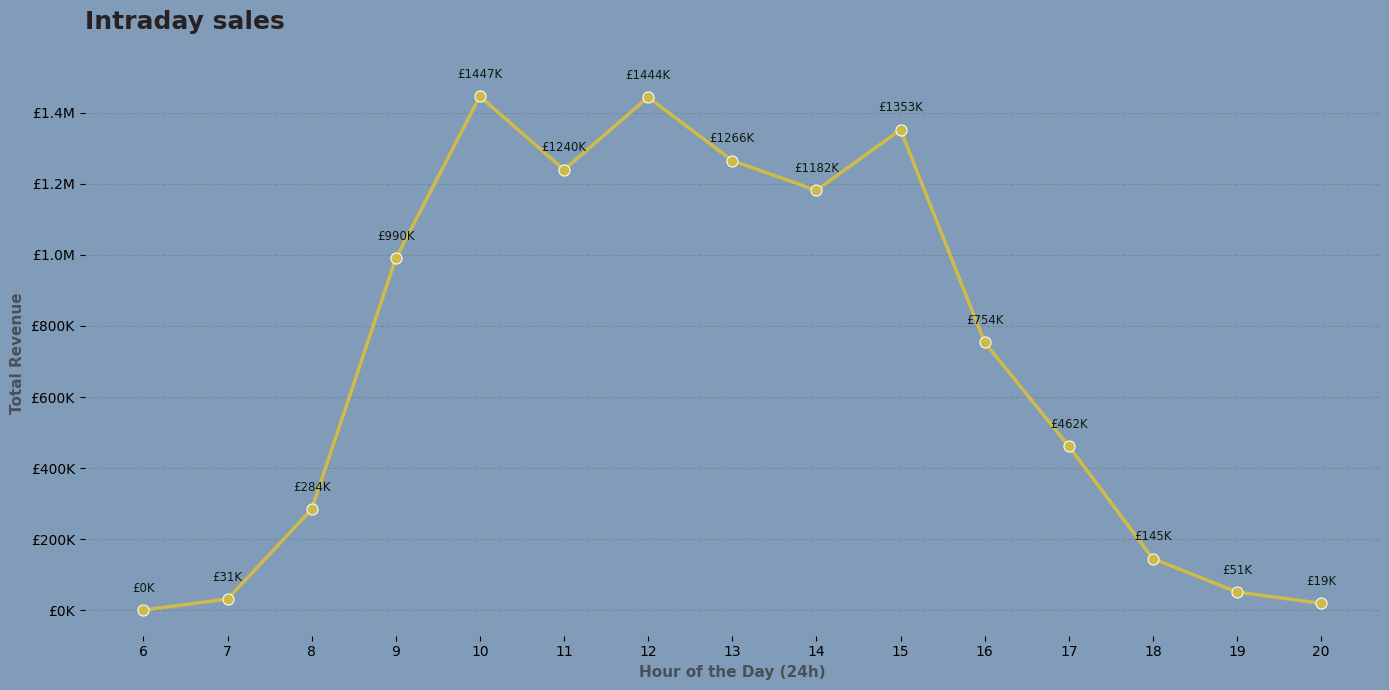

In [209]:
# Aggregating by hour
df['Hour'] = df['InvoiceDate'].dt.hour
hourly_sales = df.groupby('Hour')['TotalRevenue'].sum().reset_index()

# Styling setup
plt.rcParams['figure.facecolor'] = "#809cb8"
plt.rcParams['axes.facecolor'] = '#809cb8'

# --- 3.1.3 Hourly Sales Distribution (Refined Style) ---
plt.figure(figsize=(14, 7))


# Plotting
ax = sns.lineplot(data=hourly_sales, x='Hour', y='TotalRevenue', 
                  marker='o', markersize=8, color=line_color,
                  linewidth=2.5, label='Hourly Revenue', zorder=2)

# Adding refined annotations (not bold, smaller size)
for x, y in zip(hourly_sales['Hour'], hourly_sales['TotalRevenue']):
    plt.text(x, y + (hourly_sales['TotalRevenue'].max() * 0.03), 
             f'£{y*1e-3:.0f}K', 
             ha='center', 
             va='bottom', 
             fontsize=8.5,      # Shrunk slightly
             fontweight='normal', # Removed bold
             color=text_color)

# Layout adjustments
plt.title('Intraday sales', fontsize=18, fontweight='bold', pad=30, loc='left', color=plot_title_color)
plt.xlabel('Hour of the Day (24h)', fontsize=11, fontweight='semibold', color=x_title_color)
plt.ylabel('Total Revenue', fontsize=11, fontweight='semibold', color=y_title_color)

# Axis formatting
ax.yaxis.set_major_formatter(FuncFormatter(sterling_formatter))
plt.xticks(range(int(hourly_sales['Hour'].min()), int(hourly_sales['Hour'].max()) + 1))

# Grid and Spines cleanup
sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.3, color=grid_line_color, zorder=1)

# Removing legend as the title is descriptive enough
ax.get_legend().remove()
plt.tight_layout()
plt.show()